Face Recognition

Tina Rezvanian

# 3.	What if we want to add another person to the existing database for face recognition, or if the person in the image is not in our database?

In the previous sections, we improved on the learning of existing pretrained models of VGG16 and ResNet50, using feature extraction, transfer learning, and finetuning with data augmentation and regularization. Both aforementioned models were trained on VGGFACE2 data. So far we have compared the performance of these two architectures in the repurposed models. If we show a picture of Bill Gate to any of the models in previous section, none will identify it as Not in database. They may classify him as anyone in database. The drawback of these models is that, if we are to add another person to our database, or we want to classify those not in our database as well, then we need to retrain models to include the additionally added people in database in the classes of the final output layer.

In this section, this project explores how deep learning models can be exploited such that we can add new members to our data base or identify those not in our database. Since we already compared two architectures trained on same dataset, I want to compare a model trained on a different dataset in this section. In addition, the purpose of this section is to answer how to deal with adding more people to database, also how to classify people if we only have one image from them, or what if the image is not from someone in our database. The difference of FaceNet with previously repurposed pretrained models is that FaceNet has learned a mapping from images to embeddings, rather than to classes in the final layer. Find detailed information here(https://arxiv.org/abs/1503.03832). FaceNet model developed by  Google  and  was  trained  on  MS-Celeb-1M dataset (https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one- million-celebrities-real-world/)) and expects input images to be color, to have their pixel values standardized across all three channels, and to have a square shape of 160×160 pixels. Also, it is possible that our database contains only one picture per person. So Face net model can overcome this issue as well. Download the pretrained model from here(https://github.com/nyoki-mtl/keras-facenet). 


In [1]:
import os
import pickle
import numpy as np
import cv2
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from PIL import Image
from numpy import asarray
from scipy.spatial import distance
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras_vggface.utils import preprocess_input
import cv2
from sklearn.preprocessing import Normalizer
import warnings
warnings.simplefilter("ignore") 
%matplotlib inline

Using TensorFlow backend.


In [2]:
facenet_path = 'keras-facenet/model/facenet_keras.h5'
people_dir = 'Data/database'
test_dir = 'Data/test'
required_size = (160,160)

In [3]:
# Create functions for shrtenning the codes

In [4]:
# get embeddings of peaple's face in my dataset
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

def find_embedding(facenet_model, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = facenet_model.predict(np.expand_dims(face, axis=0))[0]
    return encode

l2_normalizer = Normalizer('l2')

def extract_face(img_path, required_size=required_size):
    # load image from file
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # create detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(img_rgb)
    # extract the bounding box associated to larger area
    bigger_face = max(results, key=lambda b: b['box'][2] * b['box'][3])
    x1, y1, width, height = bigger_face['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = img_rgb[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

def get_points(img_rgb, box):
#     extract the points in a image and its associated face
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img_rgb[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

#  Prepare our database from people image: 

The output of the FaceNet model is a vector of size (128,). This vector represents the embedding of a face. I will create a database called ‘embedding_dict’, that will include the embeddings associated to image in the database. 
1.	Create a people directory including one image per subject as the database for FaceNet model
2.	Capture embeddings of faces in database using FaceNet model
3.	Capture embeddings of candidate faces for the 11 subjects 
4.	Compare the embeddings of candidate faces with database embeddings using a distance functi


In [5]:
face_detector = MTCNN()
facenet_model = load_model(facenet_path)
required_size=(160,160)
embedding_dict = dict()

for celeb  in os.listdir(people_dir):
    if not celeb.startswith('.'):
        person_dir = os.path.join(people_dir, celeb)
        embedding_list = []
        for img_name in os.listdir(person_dir):
            if not img_name.startswith('.'):
                fullimagepath = os.path.join(person_dir, img_name)
                face = extract_face(fullimagepath)
                face = normalize(face)            
                face = cv2.resize(face, required_size)
                face = expand_dims(face, axis=0)
                embedding = facenet_model.predict(face)[0]
                embedding_list.append(embedding)

        embedding = np.sum(embedding_list, axis=0)
        embedding = l2_normalizer.transform(np.expand_dims(embedding, axis=0))[0]
        embedding_dict[celeb] = embedding

for key in embedding_dict.keys():
    print(key)
        

Teri_Hatcher
Geena_Davis
Neve_Campbell
Kevin_Bacon
Patricia_Arquette
Steve_Buscemi
Kim_Basinger
David_Duchovny
Helen_Hunt
Colin_Firth
Jeff_Goldblum


In [6]:
embedding.shape

(128,)

# Face Recognition using Repurposed FaceNet Model:
    - to identify if the candidate picture in the test_dir belongs to someone in our database, now it is sufficient to compare the embeddings that we saved in our 'embedding_dict' to the embedding of the candidate faces in the test_dir

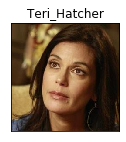

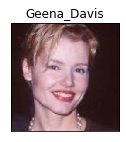

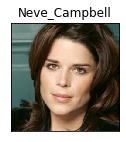

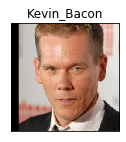

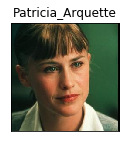

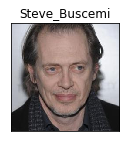

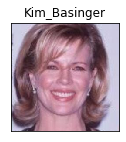

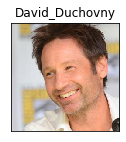

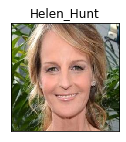

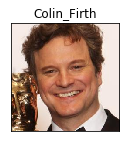

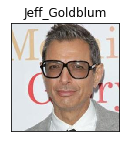

In [7]:
alpha_margin = 0.40

for celeb  in os.listdir(test_dir):
    if not celeb.startswith('.'):
        test_img_path = os.path.join(test_dir, celeb)
        if not test_img_path.startswith('.'):
            for test_img  in os.listdir(test_img_path):
                if not test_img.startswith('.'):
                    
                    test_face = extract_face(os.path.join(test_img_path, test_img))
                    test_embedding = find_embedding(facenet_model, test_face, required_size)
                    test_embedding = l2_normalizer.transform(np.expand_dims(test_embedding, axis=0))[0]
                    temp_min_distance = float("inf")
                    test_identity = 'Not in database'
                    for celeb_i in embedding_dict.keys():
                        embed_i = embedding_dict[celeb_i]
                        dissimilarity = distance.cosine(test_embedding, embed_i)
                        if dissimilarity < alpha_margin and dissimilarity < temp_min_distance:
                            test_identity = celeb_i
                            temp_min_distance = dissimilarity
                    
                    img = cv2.imread(os.path.join(test_img_path, test_img))
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(2,2))
                    plt.imshow(img_rgb)
                    plt.xticks([]), plt.yticks([])
                    plt.title(test_identity)
                    plt.show()


#  Create a generalized function for Face Recignition that can be used with all developed models:

This function identified the given faces selected in an image, given the model of interest. Then I will use this function to identify every face in a image usng model of interest.

In [28]:
def classifyFace(model,size, face):
    face = cv2.resize(face, required_size)
    temp_face = np.expand_dims(face, axis=0)
    embed = model.predict(temp_face)
    test_identity = 'Not in database'
        
    if len(embed[0])!=128:
        face = face.astype('float32')
        face = np.expand_dims(face, axis=0)
        preprocessed_face = preprocess_input(face, version=2)
        pred = model.predict(preprocessed_face)
        test_dir = 'Data/test'
        listGroupsTest = os.listdir(test_dir) 
        listGroupsTest = [f for f in listGroupsTest if not f.startswith('.')]
        
        name = np.argmax(pred, axis=-1)
        test_identity = listGroupsTest[name[0]]
       
    else:
        face = normalize(face)
        face = np.expand_dims(face, axis=0)
        pred = model.predict(face)
        
        for celeb_i in embedding_dict.keys():
            embed_i = embedding_dict[celeb_i]
            dissimilarity = distance.cosine(pred, embed_i)
            if dissimilarity < alpha_margin:
                test_identity = celeb_i

    return test_identity


# 4.	What if there are multiple faces in the images?!

IImage ‘test_3face.jpg’ includes 3 faces, 2 of which is in our database. in the following function I am performing a face recognition given a image with multiple faces in it. the prediction will be done through the model of interest, specified in the function arguments. since VGG16 and Resnet use (224,224) but FaceNet use (160,160), the required size should also be specified. this function also writes the resulting prediction on the image, and saves it with a string starting with your specified string, continued by the model name.

In [29]:
def face_recognition_multipleFaces(model, img_path, required_size, result_name):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    result_faces = detector.detect_faces(img_rgb)
    for box in result_faces:
        face_i, xy1, xy2 = get_points(img_rgb, box['box'])
        prediction = classifyFace(model, required_size, face_i)
        cv2.rectangle(img, xy1, xy2 ,(0,0, 255),3)
        cv2.putText(img,prediction, xy1,cv2.FONT_HERSHEY_PLAIN, 5, (0,0,255), 5)
    cv2.imwrite(str(result_name)+'.jpg',img)
    return img



# Comparison of models on images with multiple face:

Here I am showing the predicton of models created using transfer learning and finetuning on the convolutional base of VGG16 and Resnet50

# Comparison of Models Developed in Section 2:

Using less clear images with multiple faces and people Not in database:

# Images are saved in the model directory with name:
'result'+ modelname +str(m)+'.jpg'

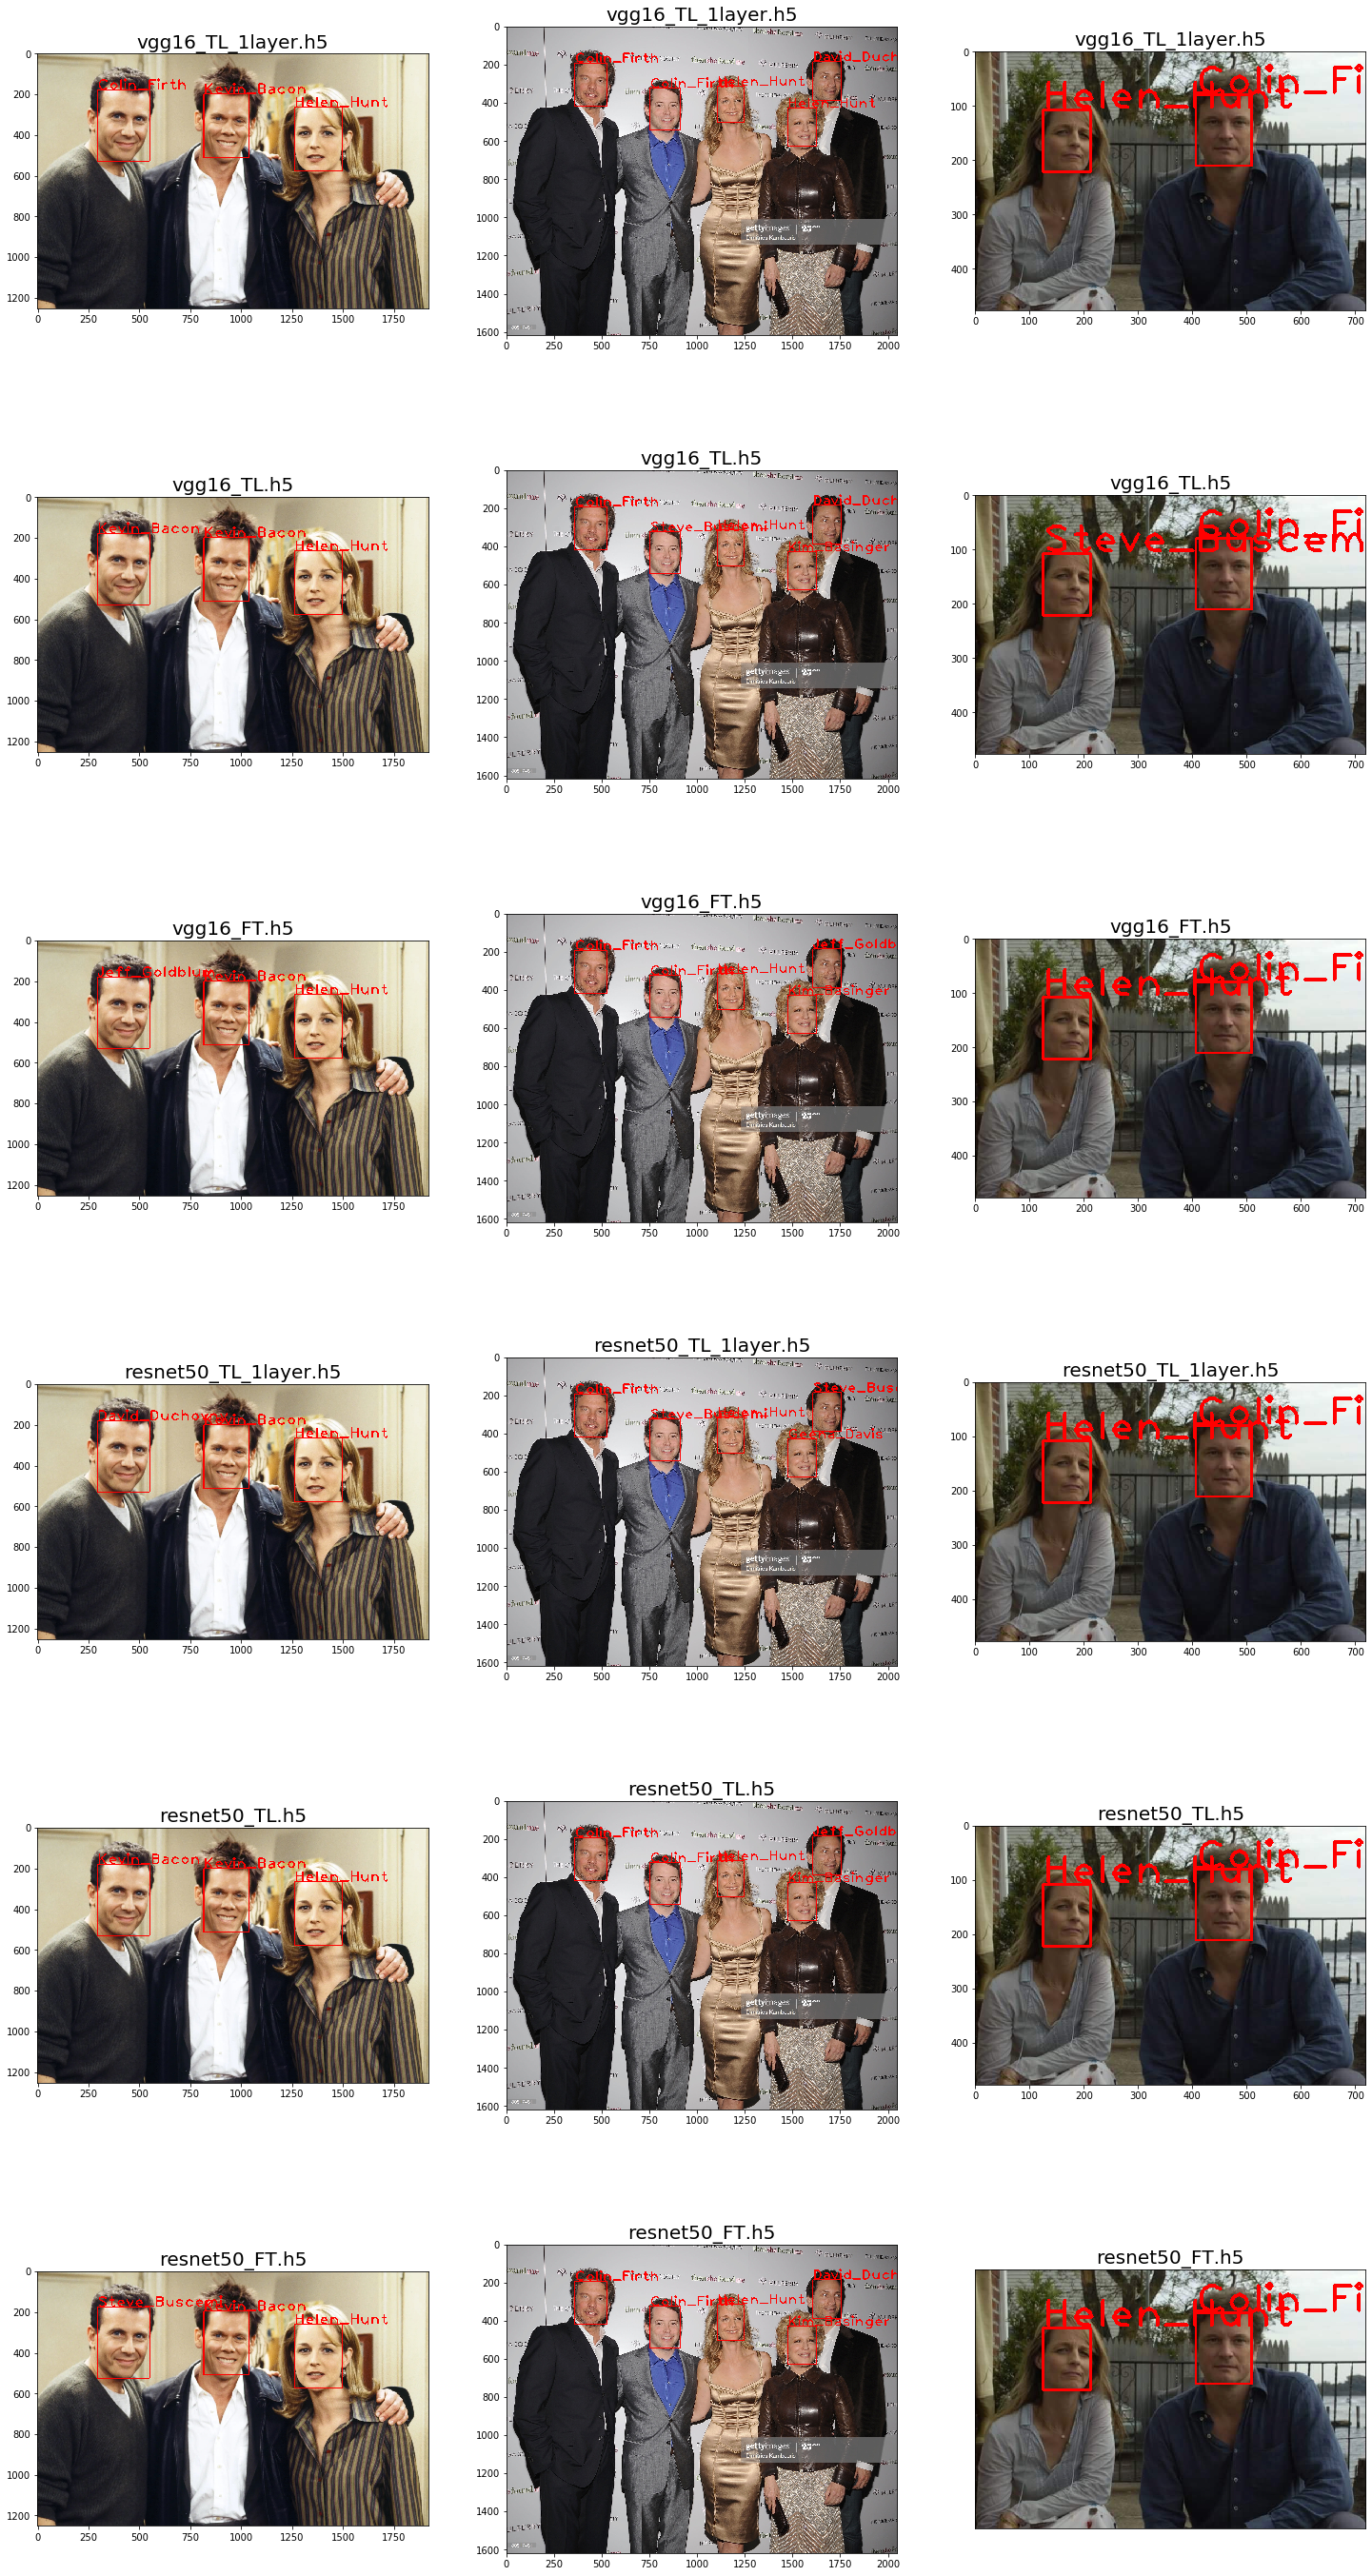

In [30]:
models= ['vgg16_TL_1layer.h5','vgg16_TL.h5','vgg16_FT.h5','resnet50_TL_1layer.h5','resnet50_TL.h5',
         'resnet50_FT.h5' ]

fig, axs = plt.subplots(len(models),3,figsize=(25, 50))
required_size=(224,224)

multi_face_imgs_path = 'multi_face_imgs'
multi_face_imgs_dir = os.listdir(multi_face_imgs_path)
for m in range(len(models)):
    modelname = models[m]
    model = load_model(modelname)
    j=0
    for multi in multi_face_imgs_dir:
        if not multi.startswith('.'):
            
            required_size = (224, 224)
            fullimagepath = os.path.join(multi_face_imgs_path, multi)
            FR_img = face_recognition_multipleFaces(model, fullimagepath, required_size, 'result'+ modelname +str(m))
            img_rgb = cv2.cvtColor(FR_img, cv2.COLOR_BGR2RGB)
            plt.xticks([]), plt.yticks([])
            axs[m,j].imshow(img_rgb)
            axs[m,j].set_title(modelname, size=20)
            j+=1


# Report:
    
    - even with less clear images, developed models correctly identified faces that are in the subject classes.
    - but those faces that are not in classes are predicted to be one of the 11 classes.

# Results fom Repurposed Model from FaceNet:

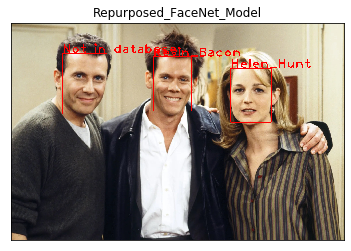

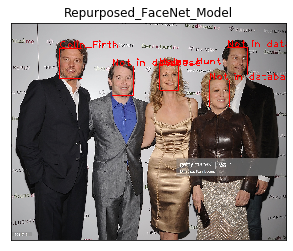

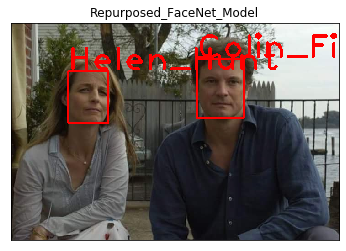

In [15]:
multi_face_imgs_path = 'multi_face_imgs'
required_size=(160,160)
multi_face_imgs_dir = os.listdir(multi_face_imgs_path)
for multi in multi_face_imgs_dir:
    if not multi.startswith('.'):
        fullimagepath = os.path.join(multi_face_imgs_path, multi)

        required_size = (160, 160)
#         print("face recognition based on model: FaceNet model")
        FR_img = face_recognition_multipleFaces(facenet_model, fullimagepath, required_size, 'result'+modelname+str(m))
        img_rgb = cv2.cvtColor(FR_img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.xticks([]), plt.yticks([])
        plt.title('Repurposed_FaceNet_Model')
        plt.show()


# Report

- the repurposed facenet model correctly predicts all faces in sample images and correctly identifies those not in database


# Highlight and Explanation of Reports:

1.	Repurposing existing models, using a moderate size dataset, to match an extracted face to a known individual can significantly improve the prediction accuracy of pretrained models.
2.	The performance of repurposed models strongly depends on the underlying network architecture and not necessarily the depth or number of layers. VGG16 yields higher validation accuracy with less layers retrained. VGG16 and Resnet50 models are both pretrained on the same VGGFace2 dataset. However, when more of the layers are retrained, model using ResNet50 improved more.
3.	Fine tuning improved the validation accuracies more than transfer learning in models created VGG16 and ResNet50’s convolutional base.
4.	Models using VGG16’s convolutional base responded better than ReNet50 to the transfer learning regardless of the 1 or 2 layers added. Models using ReNet50’s convolutional base only compensated to the same accuracy when 2  hidden dense layers were added.
5.	Model using Resnet50’s convolutional base responded better than VGG16 to finetuning. (model using VGG16 convolutional base improved from ~93% in TL to ~ 95% in FT, while using Resnet50 improved from ~93% in TL to ~97% in FT)
6.	Models in Transfer learning and finetuning provided a better fit than models created using extracted features. In transfer learning and fine tuning sections, training and validation accuracy improved together and remain very close. Models are neither overfitting nor underfitting. On the other hand, in the models created using extracted features, the validation accuracy remain less training accuracy. 
7.	The performance of repurposed models strongly depends on the number of images in the underlying datasets of pretrained models, as FaceNet with 1 million identities strongly over performs VGG16 and ResNet50 with 9,131 identities.
8.	The initial dataset used to train them and not necessarily the depth or number of layers. 
9. The performance of repurposed models strongly depends on the number of images in the underlying datasets and the learning algorithm of pretrained models. Repurposing FaceNet model with 1 million identities and one-shot learning algorithm strongly over performs initial pretrained VGG16 and ResNet50 with 3.5 million images on 9,131 identities.
